In [4]:
import dotenv
import os
import sys
from PIL import Image 
from matplotlib import pyplot
from numpy import asarray, resize, prod, array

In [27]:
from src.loader import Loader

loader = Loader((224, 224))

In [2]:
dataset = loader.create_dataset()
dataset.summary()

-------------------- Dataset Summary --------------------

Number of train images :  5216


Number of test images :  624


Number of validation images :  16


Shape of each images :  (224, 224, 3)
---------------------------------------------------------


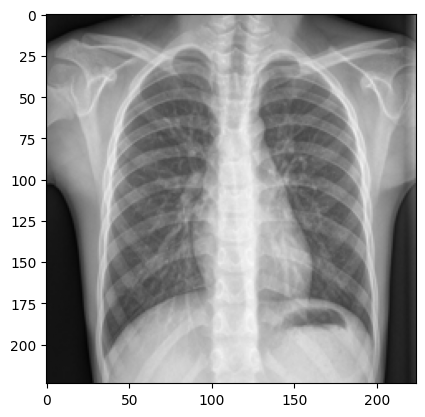

In [5]:
pyplot.imshow(dataset.test_images[0])

In [4]:
# Tensorboard init

%load_ext tensorboard
%tensorboard --logdir logs/fit

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

# VGG16

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Conv2D, Lambda, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
import tensorflow as tf

vgg_conv = VGG16(weights='./vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(vgg_conv.input, x)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.005, momentum=0.9), metrics=["accuracy"])

In [7]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(dataset.train_images, dataset.train_labels,
          epochs=25,
          batch_size=128,
          shuffle=True,
          validation_data=(dataset.val_images, dataset.val_labels),
          callbacks=[tensorboard_callback])

Epoch 1/25
41/41 [==============================] - 1133s 28s/step - loss: 0.4131 - accuracy: 0.7979 - val_loss: 1.7020 - val_accuracy: 0.6250
Epoch 2/25
41/41 [==============================] - 1142s 28s/step - loss: 0.1984 - accuracy: 0.9174 - val_loss: 0.9398 - val_accuracy: 0.7500
Epoch 3/25
41/41 [==============================] - 1168s 28s/step - loss: 0.1456 - accuracy: 0.9400 - val_loss: 0.1285 - val_accuracy: 1.0000
Epoch 4/25
41/41 [==============================] - 1221s 30s/step - loss: 0.0869 - accuracy: 0.9691 - val_loss: 0.2821 - val_accuracy: 0.8125
Epoch 5/25
 5/41 [==>...........................] - ETA: 18:11 - loss: 0.0771 - accuracy: 0.9672

KeyboardInterrupt: 

In [25]:
model.evaluate(dataset.test_images, dataset.test_labels, verbose=2)

20/20 - 64s - loss: 0.7941 - accuracy: 0.7548 - 64s/epoch - 3s/step


[0.7941068410873413, 0.754807710647583]

In [8]:
model.save_weights('./checkpoints/my_checkpoint')

In [9]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [22]:
import scipy.ndimage as sp
import matplotlib.pyplot as plt
import numpy as np

def plot_activation(img):
    pred = loaded_model2.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
    weights = loaded_model2.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = Model(loaded_model2.input,
                         loaded_model2.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    act_maps = sp.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), 
                 class_weights).reshape(img.shape[0],img.shape[1])
    plt.imshow(img.astype('float32').reshape(img.shape[0],
               img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Pneumonia' if pred_class == 1 else 'No Pneumonia')

In [23]:
# model.save('model')

loaded_model2 = tf.keras.models.load_model('model')

In [17]:
# model.save('model.h5')

# loaded_model1 = tf.keras.models.load_model('model.h5')

1/1 [==============================] - 0s 164ms/step
0


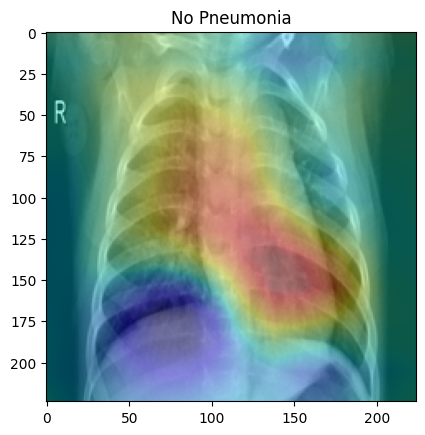

In [26]:
plot_activation(dataset.test_images[5])
print(dataset.test_labels[5])